In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

In [2]:
# semantic segmentation
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor  

In [3]:
# instance segmentation
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F

In [4]:
# panoptic segmentation
from transformers import Mask2FormerForUniversalSegmentation, AutoImageProcessor

In this script, I am going to apply 3 types of image segmentation on the same image: semantic, instance and panoptic segmentation. I am going to use pre-trained models from Huggingface.

In [5]:
# They are different because Mask R CNN uses COCO with background 0

COCO_PANOPTIC = {
    "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat", "traffic light", "fire hydrant",
    "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
    "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop",
    "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase",
    "scissors", "teddy bear", "hair drier", "toothbrush"
}

COCO_INSTANCE = [
    "__background__",
    "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat", "traffic light", "fire hydrant",
    "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
    "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop",
    "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase",
    "scissors", "teddy bear", "hair drier", "toothbrush"
]

C:\Users\Chiara\anaconda3\envs\cv\lib\site-packages\transformers\image_processing_base.py:370: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

C:\Users\Chiara\anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chiara\anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
The image processor of type `Mask2FormerImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/782 [00:00<?, ?it/s]

`label_ids_to_fuse` unset. No instance will be fused.


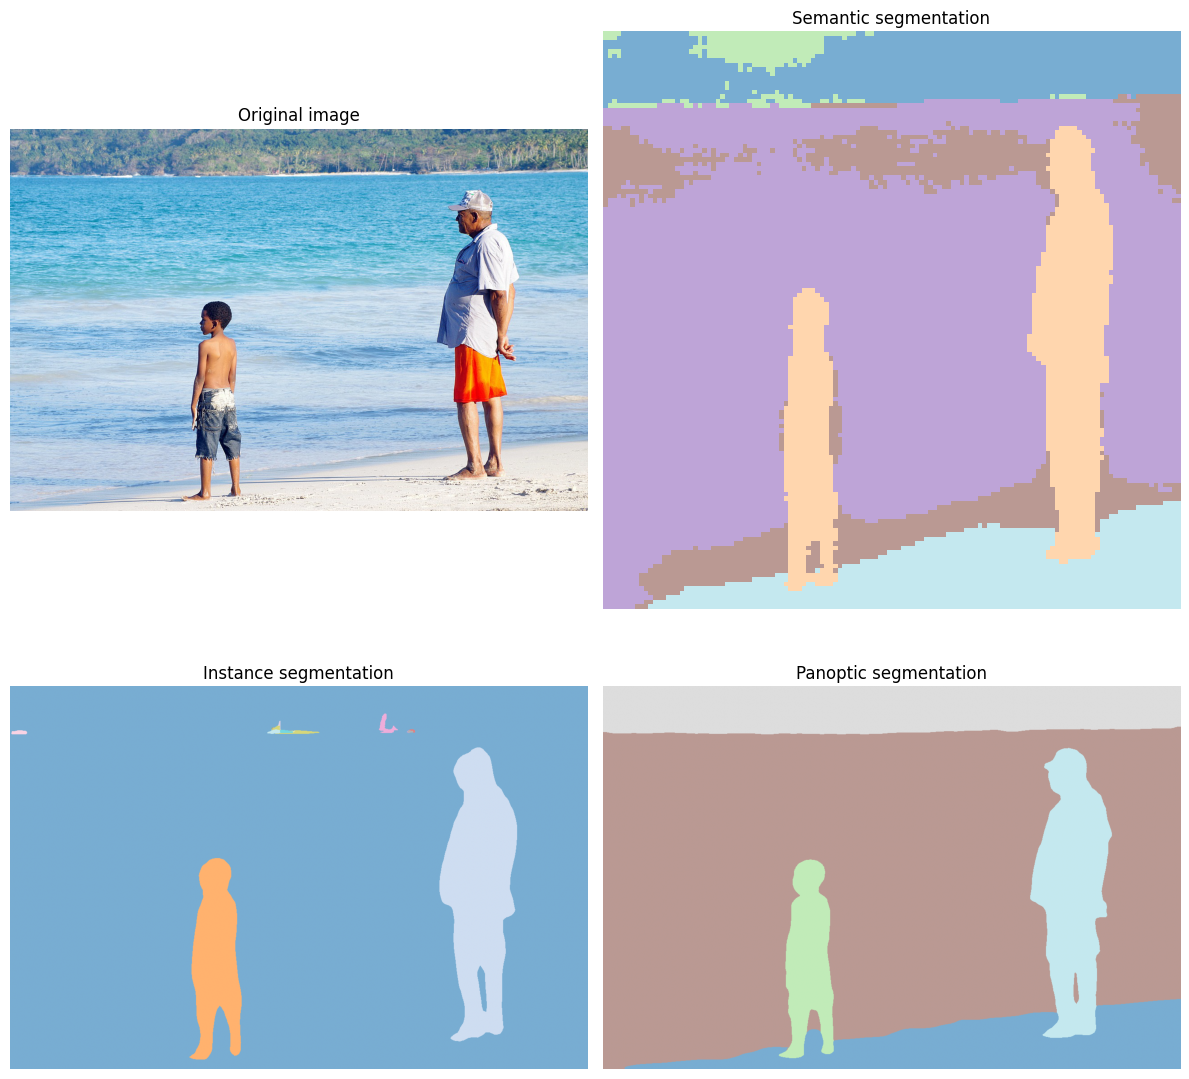

In [6]:
# ----------------- Function to show masks ----------------------------

def show_mask(mask, ax, title, alpha=0.6):
    ax.imshow(mask, cmap="tab20", alpha=alpha)
    ax.set_title(title)
    ax.axis("off")


# -------------------- Load image --------------------------------

image = Image.open("C:\\Users\\Chiara\\Pictures\\mare.jpg").convert("RGB")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original image")
axes[0, 0].axis("off")


# --------------------- SEMANTIC SEGMENTATION -> SegFormer -------------------------------

semantic_processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
semantic_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

inputs = semantic_processor(images=image, return_tensors="pt") # dimension (1, 3, H, W) where 1 = batch size.

with torch.no_grad():
    outputs = semantic_model(**inputs)

semantic_mask = outputs.logits.argmax(dim=1)[0].cpu().numpy() # for each pixel the model produces a value (logit) for each class -> choose the most likely class
show_mask(semantic_mask, axes[0, 1], "Semantic segmentation")

semantic_classes = np.unique(semantic_mask)
id2label = semantic_model.config.id2label
semantic_class_names = [id2label[int(i)] for i in semantic_classes]


# -------------------- INSTANCE SEGMENTATION -> Mask R-CNN -----------------------------------

instance_model = maskrcnn_resnet50_fpn(pretrained=True)
instance_model.eval()

img_tensor = F.to_tensor(image) # dimension (3, H, W)

with torch.no_grad():
    output = instance_model([img_tensor])[0]   # output = {
                                               #  "boxes":  Tensor[N, 4],
                                               #  "labels": Tensor[N],
                                               #  "scores": Tensor[N],
                                               #  "masks":  Tensor[N, 1, H, W]
                                               #}
                                               # N = number of istances
                                               # 1 is the number of channels of the mask for each instance 
                                               # For each instance the mask is a H x W matrix of numbers in 0,1 (probabilities) 

scores = output["scores"].cpu().numpy()
labels = output["labels"].cpu().numpy()
masks  = output["masks"].cpu().numpy()

score_threshold = 0.7
keep = scores > score_threshold  # filter by a confidence score

scores = scores[keep]
labels = labels[keep]
masks  = masks[keep]

num_instances = len(labels)

instance_mask = np.zeros(image.size[::-1], dtype=np.int32)

for i, mask in enumerate(output["masks"]): # for each instance
    instance_mask[mask[0] > 0.5] = i + 1 # if the probability is > 0.5 the pixel is considered as being part of the instance, otherwise it is considered as background

show_mask(instance_mask, axes[1,0], "Instance segmentation")

instance_classes = output["labels"].cpu().numpy()
instance_class_names = [COCO_INSTANCE[int(cid)] for cid in instance_classes]


# ------------------------- PANOPTIC SEGMENTATION -> Mask2Former -------------------------------

panoptic_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
panoptic_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

inputs = panoptic_processor(images=image, return_tensors="pt") # dimension (1, 3, H, W) where 1 = batch size.

with torch.no_grad():
    outputs = panoptic_model(**inputs)

panoptic_result = panoptic_processor.post_process_panoptic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

panoptic_mask = panoptic_result["segmentation"].cpu().numpy() # is a H x W matrix where each cell has a int number -> ID of a segment (segment = thing + stuff)
show_mask(panoptic_mask, axes[1,1], "Panoptic segmentation")

segments_info = panoptic_result["segments_info"] # is a list of dict, a dict for each segment. For example : 
                                                 # segments_info = [
                                                 #  {"id": 1, "label_id": 0,  "isthing": False}, 
                                                 #  {"id": 2, "label_id": 1,  "isthing": True}, ...
                                                 # where ids are the same of the panoptic_result["segmentation"] matrix, label is the semantic class of the segment

id2label = panoptic_model.config.id2label

segments_per_class = defaultdict(int)
instances_per_class = defaultdict(int)

for s in segments_info:
    label_id = s["label_id"]
    class_name = id2label[label_id]

    segments_per_class[class_name] += 1

    if class_name in COCO_PANOPTIC:
        instances_per_class[class_name] += 1

num_instances = sum(instances_per_class.values())


# ------------------ Results ------------------------
plt.tight_layout()
plt.show()

In [7]:
# Info on semantic segmentation

print("Semantic segmentation\n")
print("Number of classes:", len(semantic_classes))
print("Class ID:", semantic_classes)
print("Class names:")

for cid, cname in zip(semantic_classes, semantic_class_names):
    print(f"  {cid}: {cname}") 

Semantic segmentation

Number of classes: 6
Class ID: [ 4 12 16 21 26 46]
Class names:
  4: tree
  12: person
  16: mountain
  21: water
  26: sea
  46: sand


In [8]:
# info on instance segmentation

print("Instance segmentation\n")
print("Number of instances:", num_instances)
print("Instances detected:")

for i, (cid, cname) in enumerate(zip(labels, instance_class_names), start=1):
    print(f"  Instance {i}: class_id={cid}, class_name={cname}")

Instance segmentation

Number of instances: 2
Instances detected:
  Instance 1: class_id=1, class_name=person
  Instance 2: class_id=1, class_name=person


In [10]:
# info on panoptic segmentation

print("Panoptic segmentation\n")

print("Total number of segments:", len(segments_info))
for cname, count in segments_per_class.items():
    print(f"  {cname}: {count} segment(s)")

print("Total number of instances:", num_instances)
for cname, count in instances_per_class.items():
    print(f"  {cname}: {count} instance(s)")

Panoptic segmentation

Total number of segments: 5
  sand: 1 segment(s)
  person: 2 segment(s)
  sea: 1 segment(s)
  tree-merged: 1 segment(s)
Total number of instances: 2
  person: 2 instance(s)
